In [ ]:
#|default_exp ceviche_challenges

In [23]:
import numpy as np
import ceviche_challenges
from ceviche_challenges import units as u
import ceviche
from inverse_design.brushes import notched_square_brush, circular_brush
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange

import autograd
import autograd.numpy as npa

In [24]:
import jax
import jax.numpy as jnp
from javiche import jaxit
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from inverse_design.conditional_generator import generate_feasible_design_mask
from inverse_design.local_generator import generate_feasible_design_mask
from jax.example_libraries.optimizers import adam
import time


# Global flag to set a specific platform, must be used at startup.
# jax.config.update('jax_platform_name', 'cpu')

In [25]:
mpl.rcParams['figure.dpi'] = 100
mode_converter = False

For the Waveguide-Bend:

In [26]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
  wg_width=400*u.nm, variable_region_size=(1700*u.nm, 1700*u.nm), cladding_permittivity=2.25 #(1600*u.nm, 1600*u.nm)
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 25/3*2 * u.nm, wavelengths = [1270*u.nm]) #, np.arange(1260, 1300, 10)*u.nm
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

For the Modeconverter

In [27]:
if mode_converter:
  spec = ceviche_challenges.mode_converter.prefabs.mode_converter_spec_12(
    left_wg_width=400*u.nm, right_wg_width=400*u.nm, variable_region_size=(2300*u.nm, 2300*u.nm), cladding_permittivity=2.25 #(1600*u.nm, 1600*u.nm)
  )
  params = ceviche_challenges.mode_converter.prefabs.mode_converter_sim_params(resolution = 25/3*2 * u.nm, wavelengths = np.arange(1260, 1310, 10)*u.nm) #, np.arange(1260, 1300, 10)*u.nm
  model = ceviche_challenges.mode_converter.model.ModeConverterModel(params, spec)

In [28]:
#| export
import scipy.ndimage
def border_bias(model):
  width = 5
  inner = np.s_[width:-width,width:-width]
  dr = np.array(model.design_region_coords).reshape((2,2))
  bg = model.density_bg[dr[0,0]-1:dr[1,0]+1, dr[0,1]-1:dr[1,1]+1]

  border_density = np.zeros(model.design_region_shape)[inner]
  for direction in range(2):
    for sign in [-1, 1]:
      border_density+= np.roll(bg, sign*(width+1), direction)[inner][1:-1,1:-1]
  
  border_density = np.pad(border_density, mode='edge', pad_width=width)
  border_density = border_density*2-1
  border_density[inner] = 0
  border_density = scipy.ndimage.gaussian_filter(border_density, 1)
  border_density[inner] = 0
  border_mask = np.zeros_like(border_density)
  border_mask[inner] = 1
  return border_density, border_mask

In [29]:
bd, bm = border_bias(model)

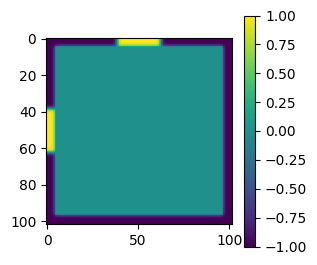

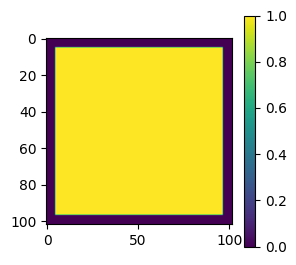

In [30]:
plt.figure(figsize=(3,3))
plt.imshow(bd)
plt.colorbar()
plt.figure(figsize=(3,3))
plt.imshow(bm)
plt.colorbar()

In [31]:
def forward(latent_weights, brush, progress, skip=False):
    if skip:
      return latent_weights
    start_time = time.process_time()
    latent_t = transform(latent_weights, brush, 5)
    #latent_t = latent_t + jnp.transpose(latent_t)
    latent_t = latent_t*bm + bd
    design_mask = generate_feasible_design_mask(latent_t, 
      brush) #, verbose=False
    design = (design_mask+1.0)/2.0
    #print(f"Forward: {time.process_time()-start_time}")
    return design

## Question: how do I know how to initialize??

In [32]:
brush = circular_brush(5)
latent = new_latent_design(model.design_variable_shape, bias=1e-2, r=2, r_scale=1e-5)

In [33]:
if mode_converter:
  brush = circular_brush(3)
  latent = new_latent_design(model.design_variable_shape, bias=1e-2, r=2, r_scale=3e-3)

In [34]:
if False:
  latent = new_latent_design(model.design_variable_shape, bias=1, r=2, r_scale=3e-2)

In [35]:
# Number of epochs in the optimization
Nsteps = 150
# Step size for the Adam optimizer
# We could do some fancy progressive stepsize
def step_size(idx):
  """reducing the stepsize linearly for Nsteps (stabilize afterwards just in case)"""
  start = 0.1
  stop = 5e-3
  return start*(stop/start)**(idx/Nsteps)

# But lets stay with the original paper...
step_size = 0.01

In [36]:
@jaxit(cache=False)
def inner_loss_fn(design):
    start_time = time.process_time()
    s_params, fields = model.simulate(design)
    
    global debug_fields, debug_design, debug_forward
    debug_fields = fields
    debug_design = design
    debug_forward = isinstance(design, np.ndarray)

    return s_params

def loss_fn(latent, step):
    global debug_forward
    design = forward(latent, brush, step/Nsteps)
    s_params = inner_loss_fn(design)

    s11 = jnp.abs(s_params[:, 0, 0])**2
    s21 = jnp.abs(s_params[:, 0, 1])**2

    if debug_forward:
      print("S21: ",10*jnp.log10(s21))
      print("S11: ",10*jnp.log10(s11))

    s = jnp.stack((s11,s21)).flatten()
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21))).flatten()

    t_s21 = 10**(-0.5/20)
    t_s11 = 10**(-20/20)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2))).flatten()
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum( jax.nn.softplus(g*(s-target)/w_min)**2 )
    return L

In [37]:
def visualize_latent(latent):
  global debug_design, debug_fields, debug_forward
  design = forward(latent, brush, 1)
  s_params, fields = model.simulate(design)
  debug_design = design
  debug_fields = fields
  debug_forward = True
  visualize_debug()

def visualize_debug(step=0):
  global debug_design, debug_fields, debug_forward
  if not isinstance(debug_fields, np.ndarray):
    debug_fields = debug_fields._value
    debug_design = debug_design._value
  
  if debug_forward:
    plt.figure(figsize=(2,2))
    ax = plt.gca()
    ceviche.viz.abs(np.asarray(debug_fields)[0], model.density(np.asarray(debug_design)), ax=ax)
    plt.grid()
    plt.axis("off")
    plt.savefig(f"out/{step:04d}.png")
    plt.show()

In [38]:
grad_fn = jax.grad(loss_fn)

init_fn, update_fn, params_fn = adam(step_size, b1=0.667, b2=0.9)
state = init_fn(latent)

debug_latent = True
debug_grad = True
def step_fn(step, state):
    latent = params_fn(state)
    if debug_latent:
      plt.figure(figsize=(2,2))
      plt.title("latent")
      ax = plt.gca()
      ceviche.viz.real(latent, ax=ax,  cbar=True)
      plt.show()
      plt.figure(figsize=(2,2))
      plt.title("latent_t")
      ax = plt.gca()
      ceviche.viz.real(transform(latent, brush), ax=ax,  cbar=True)
      plt.show()
    #print("loss")
    loss = loss_fn(latent, step)

    visualize_debug(step)
    #print("grads")
    grads = grad_fn(latent, step)

    if debug_grad:
      plt.figure(figsize=(2,2))
      plt.title("grad")
      ax = plt.gca()
      ceviche.viz.real(grads, ax=ax, cbar=True)
      plt.show()

    optim_state = update_fn(step, grads, state)
    
    # optim_latent = params_fn(optim_state)
    # print(optim_latent.mean())
    # optim_latent = optim_latent-0.2*optim_latent.mean()
    # optim_state = init_fn(optim_latent)
    # optim_latent = params_fn(optim_state)
    # plt.figure(figsize=(2,2))
    # plt.title("optim_latent")
    # ax = plt.gca()
    # ceviche.viz.real(optim_latent, ax=ax,  cbar=True)
    # plt.show()

    return loss, optim_state

FileNotFoundError: [Errno 2] No such file or directory: 'out/0000.png'

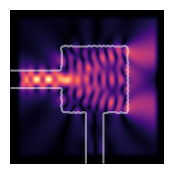

In [39]:
latent = params_fn(state)
visualize_latent(latent)

In [40]:
losses = np.zeros(Nsteps)
losses[:] = np.nan
step=0

In [41]:
def plot_losses(losses):
  plt.figure()
  plt.plot(losses)
  plt.savefig("out/loss.png")
  plt.close()

  0%|          | 0/150 [00:00<?, ?it/s]

step 0:


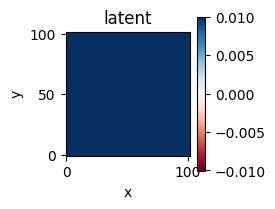

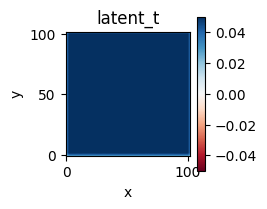

S21:  [-48.344555]
S11:  [-32.705967]


FileNotFoundError: [Errno 2] No such file or directory: 'out/0000.png'

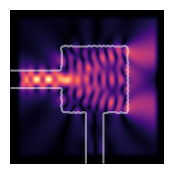

In [42]:
#|eval:false
range_ = trange(step, Nsteps)
for step in range_:
    print(f"step {step}:")
    loss, state = step_fn(step, state)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))
    plot_losses(losses)

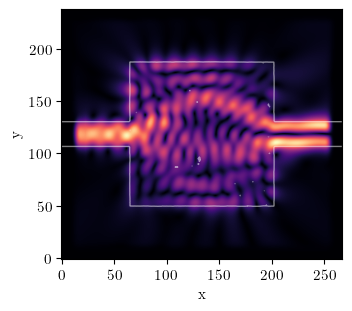

In [ ]:
latent = params_fn(state)
design = forward(latent, brush, 1)
s_params, fields = model.simulate(design)
epsr = model.epsilon_r(design)
ceviche.viz.abs(np.squeeze(fields[0]), model.density(design))
plt.grid()

Text(0, 0.5, 'Normalized Loss')

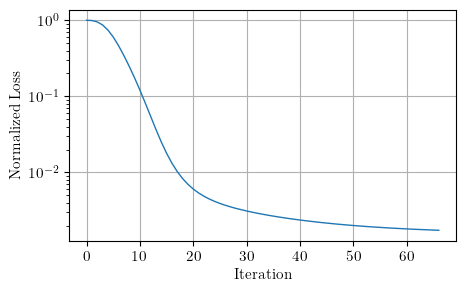

In [ ]:
plt.plot(losses/max(losses))
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Normalized Loss")